# Test implementation on 2D to 1D problems
### Problem Setup
To start testing the algorithm, we are going to try to optimize finding the absolute minima of a function with
one input and one output. Lets start defining this function:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import warnings
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.stats import norm

plt.style.use('dark_background')

In [2]:
# Implementation of the same algorithm using out own tool
from search_space import *
from evaluation_metrics import *

In [4]:
# objective function is to MAXIMIZE the value of the function
class ObjectiveFunction:
    def __init__(self):
        self.name = self.__class__.__name__
        self._params = None

    @property
    def params(self):
        return self._params

    @params.setter
    def params(self, params_dict):
        self._params = params_dict

    @params.deleter
    def params(self):
        del self._params

    def run(self):
	    return self.params["X1"]**2 * np.sin(5 * np.pi * self.params["X2"])**6

In [80]:
def random_search_optimization(search_space: SearchSpace,
                               f: ObjectiveFunction,
                               metric: callable,
                               metric_args: np.ndarray = None,
                               n_iters: int = 100,
                               ):
    explored_space = []
    for _ in range(n_iters):
        search_space.sample()
        f.params = search_space.current
        XyG = [v for v in f.params.values()]
        XyG.append(f.run())
        if metric_args is None:
            objective = metric([XyG[-1], 0, 0])
        else:
            objective = metric([XyG[-1], 0, 0], metric_args)
        XyG.append(objective)
        explored_space.append(XyG)

    explored_space = np.array(explored_space, dtype=object)

    return explored_space

In [90]:
se_dict = {
    "X1": InputValueSpace(
        se_type=float_random, params_dict={"lower_bound": 0, "upper_bound": 1}
    ),
    "X2": InputValueSpace(
        se_type=float_random, params_dict={"lower_bound": 0, "upper_bound": 1}
    ),
}

se = SearchSpace(input_dict=se_dict)
metric_weights = np.array([1, 0, 0])

explored_space = random_search_optimization(search_space=se,
                                            f=ObjectiveFunction(),
                                            metric=weighted_score,
                                            n_iters=100
                                            )

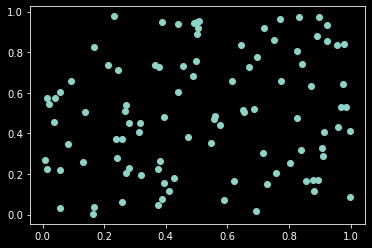

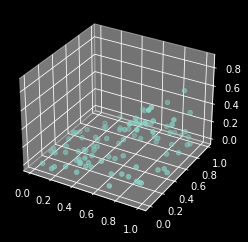

In [91]:
plt.scatter(explored_space.T[0], explored_space.T[1])
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(explored_space.T[0], explored_space.T[1], explored_space.T[-1])
plt.show()

In [92]:
## Bayesian Search

In [118]:

def bayesian_search_optimization(search_space: SearchSpace,
                                 f: ObjectiveFunction,
                                 metric: callable,
                                 metric_args: np.ndarray = None,
                                 initial_sampled_space_size: int = 100,
                                 secondary_sampled_space_size: int = 50,
                                 n_iters: int = 100,
                                 ):
    # Sample initial random space
    explored_space = []
    for _ in range(initial_sampled_space_size):
        search_space.sample()
        f.params = search_space.current
        XyG = [v for v in f.params.values()]
        XyG.append(f.run())
        if metric_args is None:
            objective = metric([XyG[-1], 0, 0])
        else:
            objective = metric([XyG[-1], 0, 0], metric_args)
        XyG.append(objective)
        explored_space.append(XyG)

    # Initialize the GPR model and fit it to the initial sampled space
    model = GaussianProcessRegressor()
    model.fit(np.array(explored_space).T[:-2].reshape(-1, len(f.params.values())),  # Input vector (sampled space)
              np.array(explored_space).T[-1].reshape(-1, 1))  # Output vector (computed metric)

    for _ in range(n_iters):
        # Find optimal value from X
        y_best = np.max(np.array(explored_space).T[-1])

        # Generate new (secondary) sampled space vector
        X_ = []
        y_ = []
        for _ in range(secondary_sampled_space_size):
            search_space.sample()
            f.params = search_space.current
            X_.append([v for v in f.params.values()])
            y_.append(f.run())
        X_ = np.array(X_).reshape(len(X_), len(f.params.values()))

        # Predict GPR values on the secondary sampled explored_space
        mu, std = model.predict(X_, return_std=True)
        mu = mu[:, 0]

        # Compute likely improvement for each space on the secondary sampled space
        probs = norm.cdf((mu - y_best) / (std + 1E-9))

        # Find best probability value and the secondary input value that generated it
        idx_best = np.argmax(probs)

        # Append best values to the main sampled space
        XyG = list(X_[idx_best])
        XyG.append(y_[idx_best])
        if metric_args is None:
            objective = metric([XyG[-1], 0, 0])
        else:
            objective = metric([XyG[-1], 0, 0], metric_args)
        XyG.append(objective)
        explored_space.append(XyG)

        # Fit again GPR with the new added pair of values
        model.fit(np.array(explored_space).T[:-2].reshape(-1, len(f.params.values())),  # Input vector (sampled space)
              np.array(explored_space).T[-1].reshape(-1, 1))  # Output vector (computed metric)

    explored_space = np.array(explored_space)

    return explored_space, model

In [129]:
se = SearchSpace(input_dict=se_dict)

explored_space, gbmodel = bayesian_search_optimization(search_space=se,
                                                            f=ObjectiveFunction(),
                                                            metric=weighted_score,
                                                            metric_args=metric_weights,
                                                            initial_sampled_space_size=100,
                                                            secondary_sampled_space_size=100,
                                                            n_iters=500)

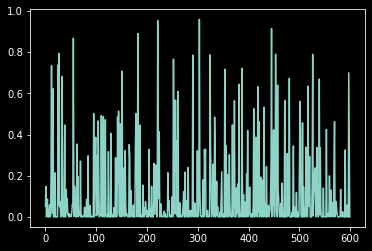

In [131]:
plt.plot(explored_space.T[-1])

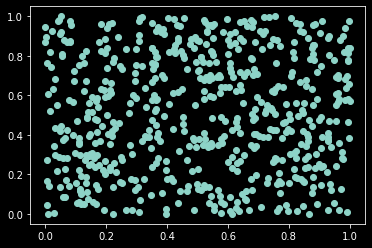

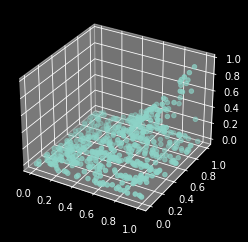

In [132]:
plt.scatter(explored_space.T[0], explored_space.T[1])
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(explored_space.T[0], explored_space.T[1], explored_space.T[-1])
plt.show()